In [1]:
import numpy as np
import ast
import scipy   
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2     
from keras.preprocessing import image    
from keras.models import Model   
import sys


In [2]:
model = tf.keras.models.load_model('saved_model/my_model')


In [3]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 layer_4 (Layer)             (None, 7, 7, 1280)        0         
                                                           

In [3]:
out1 = model.layers[-4].output

out2 = model.layers[-1].output


model = tf.keras.Model(inputs=model.input, 
    outputs=(out1, out2)) 



In [22]:
img = cv2.imread("test_images/tshirt_small.jpeg")
# img = cv2.imread("test_images/blazer.jpeg")

resized = cv2.resize(img, (224, 224))
reshaped = resized.reshape(1, 224, 224, 3)

In [5]:
all_amp_layer_weights = model.layers[-1].get_weights()[0]
labels = ['Blazer','Dress','Hat','Hoodie', 'Longsleeve','Pants', 'Polo','Shirt','Shoes','Shorts', 'Skirt','T-Shirt','Undershirt']


In [23]:
last_conv_output, pred_vec = model.predict(reshaped)
# print(last_conv_output.shape)
# print(pred_vec)

# change dimensions of last convolutional outpu tto 7 x 7 x 2048
last_conv_output = np.squeeze(last_conv_output) 
# print(last_conv_output.shape)

# get model's prediction 
pred = np.argmax(pred_vec)
print(pred, pred_vec[0][pred],labels[pred])

# bilinear upsampling to resize each filtered image to size of original image 
mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 

final_arr = []
threshold = 0.3

for val in pred_vec[0]:
    if val > threshold:
        index_of = np.where(pred_vec[0]==val)
        # get AMP layer weights
        amp_layer_weights = all_amp_layer_weights[:, index_of[0][0]]  

        # get class activation map for object class that is predicted to be in the image
        final_output = np.dot(mat_for_mult.reshape((224*224, 1280)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
        final_arr.append(final_output)




11 0.99820554 T-Shirt


In [25]:
## The code in this cell is optional. It show how to convert the heat map into a bounding box.
#The color map provides a number for each pixel
print(final_arr[0].shape)
print(len(final_arr[0]))

# Find max value in color map
max_val = np.amax(final_arr[0])
print(max_val)

for i in range(len(final_arr[0])):
    for j in range(len(final_arr[0][i])):
        # print(final_arr[])
        if final_arr[0][i][j] >= .2*max_val:
            final_arr[0][i][j]=1
        else:
            final_arr[0][i][j]=0

print(final_arr[0])


(224, 224)
224
13.900438
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


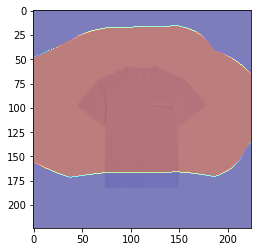

In [26]:
fig, ax = plt.subplots()

for item in final_arr:
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)

    # plot class activation map
    ax.imshow(final_arr[0], cmap='jet', alpha=0.5)